In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal
from shapely.geometry import Polygon, Point, LineString

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)

        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layerout = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=1)

        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 

        h_temp = self.activation(self.layer_3(h))
        h_temp = self.activation(self.layer_4(h_temp))
        h = h_temp + h
        
        z_out = self.layerout(h) 
        return z_out

In [3]:
class Obstacle():
    def __init__(self, boundary):
        self.boundary = Polygon(boundary)
        
    
    def trajectory_intersects(self, trajectory):
        """
        Check if a trajectory intersects with the obstacle.
        """
        traj_line = LineString(trajectory)  
        return self.boundary.intersects(traj_line)  
    
    def is_trajectory_inside(self, trajectory):
        """
        Check if an entire trajectory stays inside the obstacle.

        :param trajectory: List of (x, y) tuples representing the trajectory.
        :return: True if all points are inside the obstacle, False otherwise.
        """
        return all(self.boundary.contains(Point(p)) for p in trajectory)

    def plot(self, ax=None, color='r', alpha=0.5):
        """
        Plot the obstacle on a matplotlib figure.
        
        :param ax: Optional matplotlib axis to plot on.
        :param color: Color of the obstacle.
        :param alpha: Transparency of the obstacle.
        """
        if ax is None:
            fig, ax = plt.subplots()

        x, y = self.boundary.exterior.xy  
        # ax.fill(x, y, color=color, alpha=alpha)
        ax.plot(x, y, 'k-', linewidth=1, color=color)

class Triangle(Obstacle):
    def __init__(self, center, size):
        """
        Initialize a triangular obstacle.
        
        :param center: (x, y) center of the triangle.
        :param size: Distance from the center to the vertices.
        """
        x, y = center
        boundary = [
            (x, y + size),  # Top vertex
            (x - size, y - size),  # Bottom left
            (x + size, y - size),  # Bottom right
        ]
        super().__init__(boundary)


# Child class for Circle Obstacle
class Circle(Obstacle):
    def __init__(self, center, radius, num_points=500):
        """
        Initialize a circular obstacle.
        
        :param center: (x, y) center of the circle.
        :param radius: Radius of the circle.
        :param num_points: Number of points to approximate the circle.
        """
        x, y = center
        boundary = [(x + radius * np.cos(theta), y + radius * np.sin(theta)) 
                    for theta in np.linspace(0, 2 * np.pi, num_points)]
        super().__init__(boundary)


# Child class for Rectangle Obstacle
class Rectangle(Obstacle):
    def __init__(self, bottom_left, width, height):
        """
        Initialize a rectangular obstacle.
        
        :param bottom_left: (x, y) coordinates of the bottom-left corner.
        :param width: Width of the rectangle.
        :param height: Height of the rectangle.
        """
        x, y = bottom_left
        boundary = [
            (x, y),  # Bottom-left
            (x + width, y),  # Bottom-right
            (x + width, y + height),  # Top-right
            (x, y + height)  # Top-left
        ]
        super().__init__(boundary)

In [4]:
N = 10000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
# dt = tf/T # time step

n_sigma = 0.5 # noise level

A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [5]:
x_0 = torch.tensor([[0.0],[0.0]])
y = torch.tensor([[2.0],[2.0]])

In [6]:
t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid shape (T,1)

In [7]:
def generate_phit(t, n):
    """
    t shape is (T, 1), output shape is (T, n, n)
    """
    T, _ = t.shape
    phi_t = torch.zeros((T, n, n))
    phi_t[:,0,0] = t[:,0]**3/3
    phi_t[:,0,1] = t[:,0]**2/2
    phi_t[:,1,0] = t[:,0]**2/2
    phi_t[:,1,1] = t[:,0]
    return phi_t

In [8]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,1), output shape is (T,n,n)
    """
    T, _ = t.shape
    A_rep = A.repeat(T,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [9]:
exp1tAtrans = generate_expAt(A.T, 1-t)
expA = generate_expAt(A, torch.ones_like(t))[0,:,:]
phi_1 = generate_phit(torch.ones_like(t), n)

U_d = torch.einsum('tij,tjk->tik', torch.einsum('ij,tjk->tik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1)) @ (y - expA @ x_0).squeeze(-1)

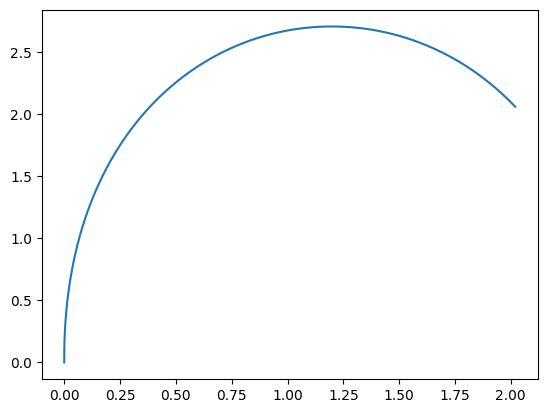

In [10]:
dt = t[1] - t[0]
X_forward = torch.zeros((T, n))
X_forward[0,:] = x_0.squeeze(-1)
for i in range(1, T):
    # print(i)
    X_forward[i,:] = (A @ X_forward[i-1,:] + B @ U_d[i-1,:]) * dt + X_forward[i-1,:]

plt.figure()
plt.plot(X_forward[:,0], X_forward[:,1])
plt.show()

In [11]:
### Generate backward data
X_backward = torch.zeros((T, N, n))
X_backward[-1,:,:] = y.repeat(N,1).reshape(N,n)
for i in range(T-1, 0, -1):
    # print(i)
    dX = (A @ X_backward[i,:,:].T  + B @ U_d[i-1,:].repeat(N,1).T).T * dt + (B @ (n_sigma * torch.randn(N,1)*np.sqrt(dt)).T).T
    X_backward[i-1,:,:] = X_backward[i,:,:] - dX

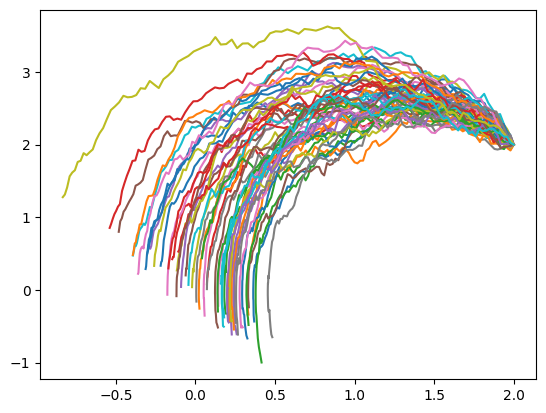

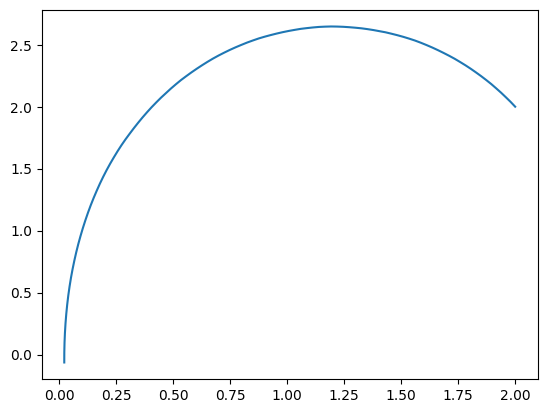

In [12]:
plt.figure()
for i in range(50):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1])
plt.show()

plt.figure()
plt.plot(X_backward[:,:,0].mean(axis=1), X_backward[:,:,1].mean(axis=1))
plt.show()

/var/folders/pd/hp6m3j2j5v9bd6w64h7wl3rm0000gn/T/ipykernel_86100/347105828.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k-', linewidth=1, color=color)


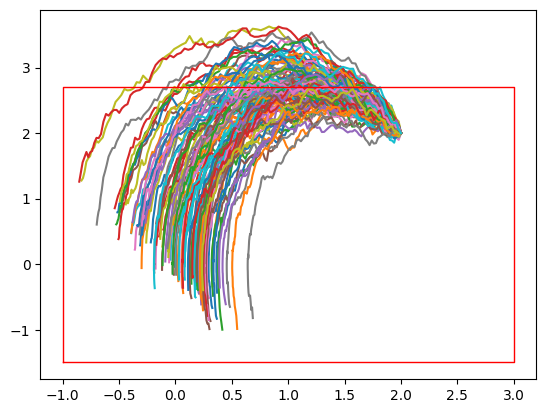

In [13]:
control_set = Rectangle((-1, -1.5), 4, 4.2)
control_set_eli = Rectangle((-1, -1.5), 4, 4)
# obs_eli = Circle((1, 2.6), 0.3)
# obs = Rectangle((0.3, 1.3), 0.5, 0.5)
plt.figure()
for i in range(100):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1])
control_set.plot(ax=plt.gca())
plt.show()


In [14]:
def elitraj(X, obstacle):
    """
    X shape is (T, N, n), output shape is (T, k, n)
    """
    T, N, n = X.shape
    k = 0
    for i in range(N):
        if obstacle.is_trajectory_inside(X[:,i,:]):
            k += 1
    X_elimited= torch.zeros((T, k, n))
    j = 0
    for i in range(N):
        if obstacle.is_trajectory_inside(X[:,i,:]):
            X_elimited[:,j,:] = X[:,i,:]
            j += 1
    return X_elimited

In [15]:
X_elimited = elitraj(X_backward, control_set_eli)   

In [16]:
X_elimited.shape

torch.Size([100, 1386, 2])

/var/folders/pd/hp6m3j2j5v9bd6w64h7wl3rm0000gn/T/ipykernel_86100/347105828.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k-', linewidth=1, color=color)


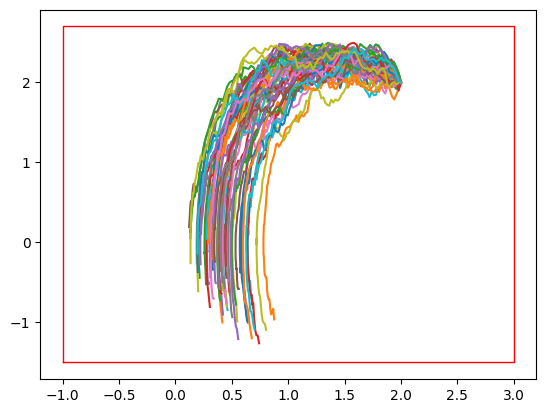

In [17]:
plt.figure()
for i in range(50):
    plt.plot(X_elimited[:,i,0], X_elimited[:,i,1])
control_set.plot(ax=plt.gca())
plt.show()

In [18]:
traj_num = X_elimited.shape[1]

In [19]:
def jacobian(y: torch.Tensor, x: torch.Tensor, need_higher_grad=True) -> torch.Tensor:
    (Jac,) = torch.autograd.grad(
        outputs=(y.flatten(),),
        inputs=(x,),
        grad_outputs=(torch.eye(torch.numel(y)),),
        create_graph=need_higher_grad,
        allow_unused=True,
        is_grads_batched=True
    )
    if Jac is None:
        Jac = torch.zeros(size=(y.shape + x.shape))
    else:
        Jac.reshape(shape=(y.shape + x.shape))
    return Jac

In [20]:
def batched_jacobian(batched_y:torch.Tensor,batched_x:torch.Tensor,need_higher_grad = True) -> torch.Tensor:
    sumed_y = batched_y.sum(dim = 0) # y_shape
    J = jacobian(sumed_y,batched_x,need_higher_grad) # y_shape x N x x_shape
    
    dims = list(range(J.dim()))
    dims[0],dims[sumed_y.dim()] = dims[sumed_y.dim()],dims[0]
    J = J.permute(dims = dims) # N x y_shape x x_shape
    return J

In [21]:
# x = torch.tensor([[1.0],[2.0]], requires_grad=True)
# y = torch.stack((x[0]**2 + x[1]**2, x[0]*x[1]))
# jac = jacobian(y, x)
# jac[:,:,0]

In [22]:
# x = torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0],[7.0,8.0],[9.0,10.0]], requires_grad=True)
# y = torch.stack((x[:,0]**2 + x[:,1]**2, x[:,0]*x[:,1]),dim=1)
# Bjac = batched_jacobian(y, x)
# Bjac

In [23]:
# temp_test = torch.einsum('ij,tjk->tik', B@B.T, Bjac)
# BatchTrace_test = temp_test.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
# BatchTrace_test

In [24]:
### learning k(x,t)###
t_N = t.repeat(1,N).reshape(T,N,1)
ITERS = 12000
BATCH_SIZE = 32
LR = 1e-4

k = score_nn(n,16)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=500, gamma=0.99)

losses = []
for i in range(ITERS):
    # print(i)
    idx = torch.randperm(traj_num)[:BATCH_SIZE]
    X_train = X_elimited[:,idx,:]
    X_train = X_train.view(-1, n)
    t_train = t_N[:,idx,:]  
    t_train = t_train.view(-1, 1)
    X_train.requires_grad = True
    k_value = k.forward(X_train, t_train) 
    # print(k_value.shape)
    gk = k_value @ B.T # shape (T*B, n)
    # gk = gk.unsqueeze(1) # shape (T*B, 1, n)
    batch_norm = torch.einsum('tij,tjk->tik', gk.unsqueeze(1), gk.unsqueeze(2)).squeeze(-1) # shape (T*B,1)
    # loss = score_norm

    batch_jac = batched_jacobian(gk, X_train)
    temp = torch.einsum('ij,tjk->tik', B@B.T, batch_jac)
    batch_trace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
    loss = (0.5*batch_norm + batch_trace).sum()/BATCH_SIZE/T
    

    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%1000==0:
        k_value = k.forward(X_train, t_train) 
        gk = k_value @ B.T
        score_norm = torch.sum(gk**2)/BATCH_SIZE/T
        loss = score_norm
        
        BatchJac = batched_jacobian(gk, X_train)
        temp = torch.einsum('ij,tjk->tik', B@B.T, BatchJac)
        BatchTrace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
        loss = 0.5*loss + BatchTrace.sum()/BATCH_SIZE/T
        losses.append(loss.item())

        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 1000/20000, loss = -2.981503248215
Iteration: 2000/20000, loss = -9.940546035767
Iteration: 3000/20000, loss = -15.491205215454
Iteration: 4000/20000, loss = -15.477043151855
Iteration: 5000/20000, loss = -19.613002777100
Iteration: 6000/20000, loss = -19.434633255005
Iteration: 7000/20000, loss = -22.629783630371
Iteration: 8000/20000, loss = -21.435132980347
Iteration: 9000/20000, loss = -22.561510086060
Iteration: 10000/20000, loss = -25.914623260498
Iteration: 11000/20000, loss = -25.801834106445
Iteration: 12000/20000, loss = -23.966775894165
Iteration: 13000/20000, loss = -29.509260177612
Iteration: 14000/20000, loss = -27.837383270264
Iteration: 15000/20000, loss = -22.718101501465
Iteration: 16000/20000, loss = -23.464366912842
Iteration: 17000/20000, loss = -25.923563003540
Iteration: 18000/20000, loss = -31.686841964722
Iteration: 19000/20000, loss = -27.361934661865
Iteration: 20000/20000, loss = -29.674730300903


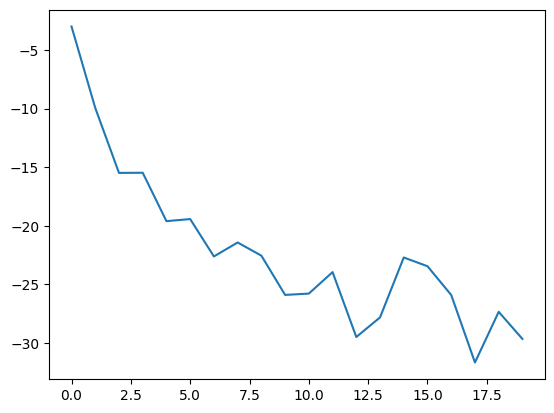

In [25]:
plt.figure()
plt.plot(losses)
plt.show()


In [26]:
exp1tAtrans = generate_expAt(A.T, 1-t)
phi1t = generate_phit(1-t, n)
exp1tA = generate_expAt(A, 1-t)
expt1A = generate_expAt(A, t-1)


In [27]:
y = torch.tensor([[2.0],[2.0]])

In [28]:
W_forward = torch.zeros((T, N, 1))
for i in range(T):
    W_forward[i,:,:] = torch.randn(N,1)*np.sqrt(dt)

In [35]:
k_record = torch.zeros((T, N, 1))
u_s_record = torch.zeros((T, N, 1))
u1_record = torch.zeros((T, N, 1))
u2_record = torch.zeros((T, N, 1))
u3_record = torch.zeros((T, N, 1))
X_pred = torch.zeros((T, N, n))
X_pred[0,:,:] = torch.zeros((N,n))
X_pred2 = torch.zeros((T, N, n))
X_pred2[0,:,:] = torch.zeros((N,n))
X_pred3 = torch.zeros((T, N, n))
X_pred3[0,:,:] = torch.zeros((N,n))

for i in range(1, T):

    ## NN method
    k_value = k.forward(X_pred[i-1,:,:], t[i-1].repeat(N,1))
    k_record[i-1,:,:] = k_value
    u = U_d[i-1,:].repeat(N,1) + k_value
    u1_record[i-1,:,:] = u
    dX = (A @ X_pred[i-1,:,:].T  + B @ u.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred[i,:,:] = X_pred[i-1,:,:] + dX

    ## u deterministic + u stochastic method
    u_s_record[i,:,:] = -(X_pred2[i-1,:,:] - X_forward[i-1,:])@ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u2 = U_d[i-1,:].repeat(N,1) + u_s_record[i,:,:]
    u2_record[i-1,:,:] = u2
    dX2 = (A @ X_pred2[i-1,:,:].T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2
    
    ## u feedback method
    u3 = -(X_pred3[i-1,:,:] - (expt1A[i-1,:,:] @ y).repeat(1,N).T) @ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u3_record[i-1,:,:] = u3
    dX3 = (A @ X_pred3[i-1,:,:].T  + B @ u3.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred3[i,:,:] = X_pred3[i-1,:,:] + dX3
    

/var/folders/pd/hp6m3j2j5v9bd6w64h7wl3rm0000gn/T/ipykernel_86100/347105828.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k-', linewidth=1, color=color)


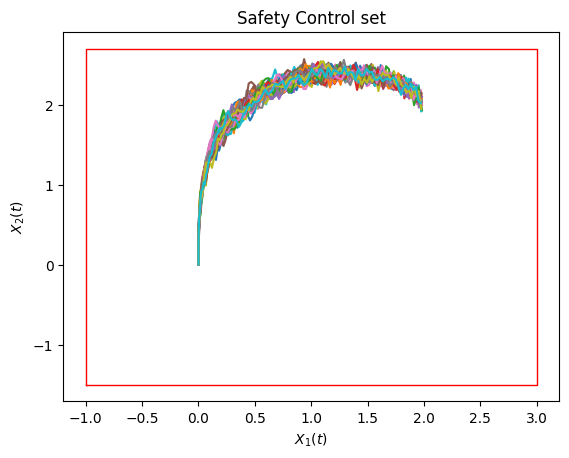

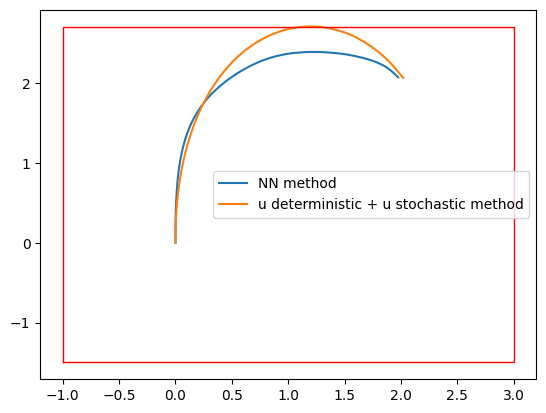

In [36]:
plt.figure()
for i in range(50):
    plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy())
control_set.plot(ax=plt.gca())
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.title("Safety Control set")
plt.show()

plt.figure()
plt.plot(X_pred[:,:,0].mean(axis=1).detach().numpy(), X_pred[:,:,1].mean(axis=1).detach().numpy(), label='NN method')
plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy(), label='u deterministic + u stochastic method')
control_set.plot(ax=plt.gca())
plt.legend()
plt.show()

/var/folders/pd/hp6m3j2j5v9bd6w64h7wl3rm0000gn/T/ipykernel_86100/347105828.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k-', linewidth=1, color=color)


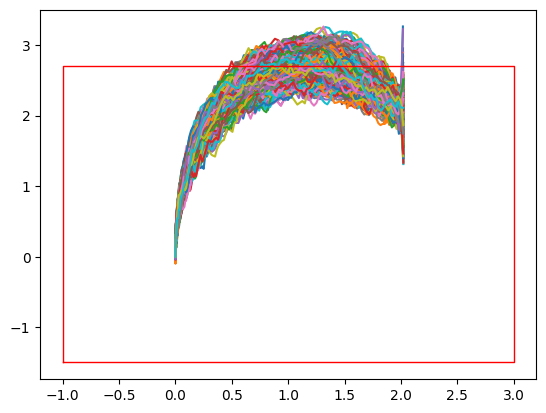

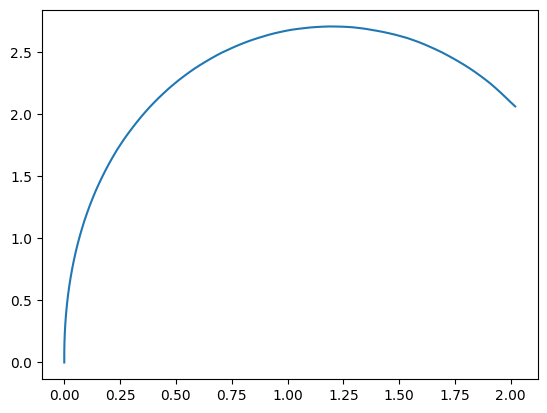

In [37]:
plt.figure()
for i in range(2000):
    plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy())
control_set.plot(ax=plt.gca())
plt.show()

plt.figure()
plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy())
plt.show()

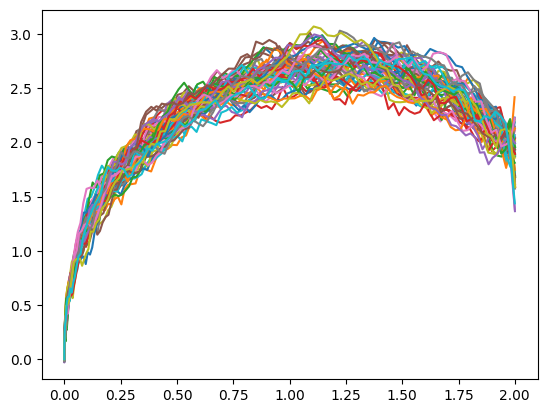

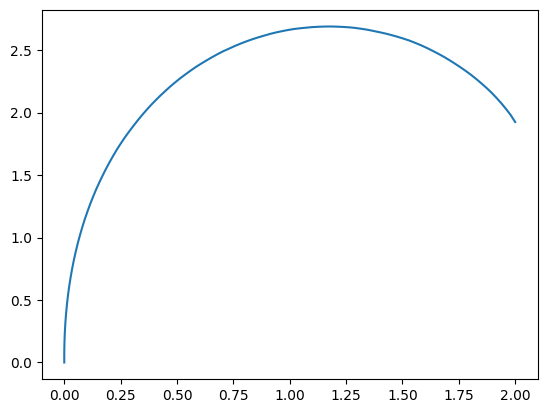

In [38]:
plt.figure()
for i in range(50):
    plt.plot(X_pred3[:,i,0].detach().numpy(), X_pred3[:,i,1].detach().numpy())
plt.show()

plt.figure()
plt.plot(X_pred3[:,:,0].mean(axis=1).detach().numpy(), X_pred3[:,:,1].mean(axis=1).detach().numpy())
plt.show()

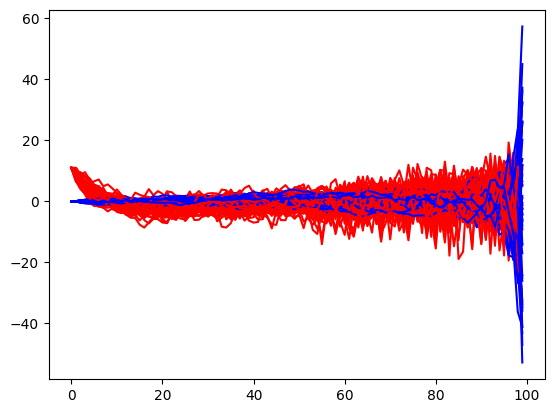

In [42]:
plt.figure()
for i in range(50):
    plt.plot(k_record[:,i,0].detach().numpy(), color='r')
    plt.plot(u_s_record[:,i,0].detach().numpy(), color='b')
plt.show()

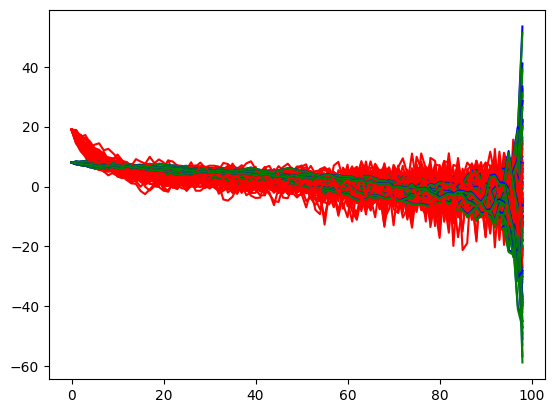

In [40]:
plt.figure()
for i in range(50):
    plt.plot(u1_record[:99,i,0].detach().numpy(), color='r')
    plt.plot(u2_record[:99,i,0].detach().numpy(), color='b')
    plt.plot(u3_record[:99,i,0].detach().numpy(), color='g')
plt.show()